### Linear Regression vs Decision Tree Regression - Car Price Prediction

In this Notebook, we will solve a simple problem of Car Price Prediction using both Linear Regression and Decistion Tree Regressor.


#### Data Gathering - First hand Analysis

In [ ]:
# Data Processing
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#For Data Pre-Processing
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, OneHotEncoder
#For Feature Selection, Train-Test-Split
from sklearn.model_selection import train_test_split
# For Fitting the ML Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
# For Model Measurement
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, multilabel_confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import graphviz

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# The Data CSV can be downloaded at the Kaggle link given above
# Data imported, no null values reported here
data_original = pd.read_csv("CarPrice_Assignment.csv")
data_original.info()  
#data_original.doornumber.value_counts()

In [ ]:
# Determines if there are duplicate rows, and marks respective (one of the rows) as True.
# Looks like no duplicate rows, hence nothing to clean-up
# To convert data type
pd.set_option('max_rows',0)
pd.set_option('max_columns',0)
data_original.duplicated().sum()

In [ ]:
# NULL Values - Let's analyze Missing Numbers and Percentages by Column wise
data_null_pct = data_original.isna().mean().round(4)*100
data_null_pct

### 2. Exploratory Data Analysis

In [ ]:
# Numerical Data Understanding
df_desc_num = data_original.describe()
num_col_names = df_desc_num.columns

In [ ]:
# Catagorical/Object Data Understanding
data_original.describe(include='O')

In [ ]:
# UNIQUE VALUES - This tells us Unique values across an Axis, in this case, Columnar, so counting axis is 0 here. 
# Compare this with Merge axis for columns, which is 1, just a side note.
data_original.nunique(axis=0)
# data_original.describe()

#### Inferences from Above
* We can see that there are no variables with a single unique value (Zero Variance)
    * If any they are not good for model selection, in this cases, we have none
* Car name - We can refine a bit as the count of names for 200+ population looks huge
* Other numerical and categorical values look okay, we need understand their importance


In [ ]:
# Do a bit closer Analysis of Output variable - Price
sns.boxplot(x='price',data=data_original)
plt.show()
sns.distplot(x=data_original['price'], axlabel="axlabel")
plt.show()
print(f"Mean: {data_original.price.mean()}, Median: {data_original.price.median()}")

#### Pairplots for All Numeric Variables

In [ ]:
# Bi Variate Pairwise analysis of all Features
sns.pairplot(data_original[num_col_names])
plt.show()
plt.figure(figsize=(20,15))
sns.heatmap(data_original.corr(), cmap='PiYG', annot=True)
plt.show()

#### Inferences from Above Analysis
Car_ID has no relation to price, can be dropped
car length, car width, curb weight, enginesize, horsepower are positively linearly corelated with price
citympg, highwaympg have negative linear corelation with price
However citympg, highwaympg have positive corelation with each other. We need to remove one of them
Also, there are other parameters that have high Multi colienarity. We will look at them

#### Visualize Categorical Variables

In [ ]:
data_original.head()

In [ ]:
cat_col_names=data_original.select_dtypes('object').columns.values
for col in cat_col_names:
    sns.boxplot(x=col, y='price',data=data_original)
    plt.show()

#### Inferences from Above Analysis
Except Car Name and Door number, every other categorical variable has a significance in influencing the output variables. We can visualize that based on the quartiles of the box plots

### 3. Feature Engineering
1. Introduce Car_PriceRange as a Category
2. Transform Car Name to Make
3. Make Data Types consistent for Car Price Range, Door number
4. Remove Unwanted Columns - Car ID, Car Name, CityMPG

In [169]:
pd.set_option('max_columns',50)
pd.set_option('max_rows',500)

In [170]:
# As the Price is right skewed and majority data is centeed below 20000, its good to have that fact as a column
# So, we do a tricky logic here to first add mean for each cat name based on price -> GroupBy, Aggregation, followed by join, and binning 
# Use Cut method to bin Cars based on price range
df2 = data_original.copy()
df2['Make'] = [carname.split(' ')[0] for carname in df2['CarName']]

In [171]:
df_price_buckets = df2.groupby(['Make'])['price'].mean()
df2 = df2.merge(df_price_buckets, how='left', on='Make')
df2.head
# Now, using cut method, let's bin the Cars - Convert Continuous Price to categorical ranges
bins = [0,10000,20000,40000]
labels = ["Entry","Mid","High"]
df2['Cars_Category']=pd.cut(df2['price_y'],bins=bins, labels=labels)
df2['price'] = df2['price_x']
df2.head(100)
df2.columns

Index(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price_x', 'Make', 'price_y', 'Cars_Category', 'price'],
      dtype='object')

In [ ]:
df2.head()

In [172]:
# Car Name - Simplify to Make - we could keep only the Make names, not model.
# Anyway, other parameters have model specific nuances, so we should be good that way
#df2 = data_original.copy()
df2.shape
df2 = df2.drop(['car_ID','CarName','price_x','price_y'], axis=1)
df2.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,Make,Cars_Category,price
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,alfa-romero,Mid,13495.0
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,alfa-romero,Mid,16500.0
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,alfa-romero,Mid,16500.0
3,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,audi,Mid,13950.0
4,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,audi,Mid,17450.0


In [173]:
# Make Name consistency - with case, spellings & abbreviations
df2['Make']=df2['Make'].replace({'vokswagen':'Volkswagen','vw':'Volkswagen','volkswagen':'Volkswagen'})
df2['Make']=df2['Make'].replace({'toyouta':'Toyota','toyota':'Toyota'})
df2['Make']=df2['Make'].replace({'nissan':'Nissan'})
df2['Make']=df2['Make'].replace({'maxda':'Mazda','mazda':'Mazda'})
df2['Make']=df2['Make'].replace({'porsche':'Porsche'})
print(df2['Make'].value_counts())
print("Total number of Makes-->>",len(df2['Make'].unique()))
df2.columns

Toyota         32
Nissan         18
Mazda          17
honda          13
mitsubishi     13
Volkswagen     12
subaru         12
peugeot        11
volvo          11
dodge           9
bmw             8
buick           8
audi            7
plymouth        7
saab            6
Porsche         4
isuzu           4
alfa-romero     3
jaguar          3
chevrolet       3
renault         2
mercury         1
porcshce        1
Name: Make, dtype: int64
Total number of Makes-->> 23


Index(['symboling', 'fueltype', 'aspiration', 'doornumber', 'carbody',
       'drivewheel', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'enginetype', 'cylindernumber', 'enginesize',
       'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'Make', 'Cars_Category', 'price'],
      dtype='object')

In [174]:
#Let's handle some Categorical columns' data types appropriately
df2['Cars_Category'] = df2['Cars_Category'].astype('str')
df2['symboling'] = df2['symboling'].astype('str')

In [175]:
df2.drop(['citympg'],axis=1,inplace=True)

In [176]:
df2.head()
df_dtr = df2

In [177]:
# Do one hot encoding for Categorical values
cat_col_names=df2.select_dtypes('object').columns.values
df2 = pd.get_dummies(df2, columns=cat_col_names, drop_first=True)
df2.head()

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,highwaympg,price,symboling_-2,symboling_0,symboling_1,symboling_2,symboling_3,fueltype_gas,aspiration_turbo,doornumber_two,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,...,fuelsystem_spfi,Make_Nissan,Make_Porsche,Make_Toyota,Make_Volkswagen,Make_alfa-romero,Make_audi,Make_bmw,Make_buick,Make_chevrolet,Make_dodge,Make_honda,Make_isuzu,Make_jaguar,Make_mercury,Make_mitsubishi,Make_peugeot,Make_plymouth,Make_porcshce,Make_renault,Make_saab,Make_subaru,Make_volvo,Cars_Category_High,Cars_Category_Mid
0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,27,13495.0,0,0,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,27,16500.0,0,0,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,26,16500.0,0,0,1,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,30,13950.0,0,0,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,22,17450.0,0,0,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [178]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 0 to 204
Data columns (total 71 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   wheelbase              205 non-null    float64
 1   carlength              205 non-null    float64
 2   carwidth               205 non-null    float64
 3   carheight              205 non-null    float64
 4   curbweight             205 non-null    int64  
 5   enginesize             205 non-null    int64  
 6   boreratio              205 non-null    float64
 7   stroke                 205 non-null    float64
 8   compressionratio       205 non-null    float64
 9   horsepower             205 non-null    int64  
 10  peakrpm                205 non-null    int64  
 11  highwaympg             205 non-null    int64  
 12  price                  205 non-null    float64
 13  symboling_-2           205 non-null    uint8  
 14  symboling_0            205 non-null    uint8  
 15  symbol

### 4. Model Generation

In [ ]:
# Model Selection
# Let's now start with Linear Regression Model for this problem
# And then, we will use OLS. 

In [179]:
df2.head()

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,highwaympg,price,symboling_-2,symboling_0,symboling_1,symboling_2,symboling_3,fueltype_gas,aspiration_turbo,doornumber_two,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,...,fuelsystem_spfi,Make_Nissan,Make_Porsche,Make_Toyota,Make_Volkswagen,Make_alfa-romero,Make_audi,Make_bmw,Make_buick,Make_chevrolet,Make_dodge,Make_honda,Make_isuzu,Make_jaguar,Make_mercury,Make_mitsubishi,Make_peugeot,Make_plymouth,Make_porcshce,Make_renault,Make_saab,Make_subaru,Make_volvo,Cars_Category_High,Cars_Category_Mid
0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,27,13495.0,0,0,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,27,16500.0,0,0,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,26,16500.0,0,0,1,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,30,13950.0,0,0,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,22,17450.0,0,0,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [180]:
X = df2.drop(['price'], axis=1)
y = df2['price']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=25)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### 5. Model Accuracy

In [202]:
y_pred = model.predict(X_test)
print("Mean Squared Error-->", np.round(np.sqrt(mean_squared_error(y_test,y_pred)),4))
print("R Squared Value-->", np.round(r2_score(y_test,y_pred),4))
print(model.score)

Mean Squared Error--> 2411.9128
R Squared Value--> 0.9164
<bound method RegressorMixin.score of LinearRegression()>


### 6. Decision Tree Regressor

In [203]:
# For Simplicity, we are taking only numeric fields for demo purpose
num_col_names = df_dtr.select_dtypes('number').columns.values
df_dtr_numeric = df_dtr[num_col_names]
df_dtr_numeric

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,highwaympg,price
0,88.6,168.8,64.1,48.8,2548,130,3.47,2.680,9.00,111,5000,27,13495.000
1,88.6,168.8,64.1,48.8,2548,130,3.47,2.680,9.00,111,5000,27,16500.000
2,94.5,171.2,65.5,52.4,2823,152,2.68,3.470,9.00,154,5000,26,16500.000
3,99.8,176.6,66.2,54.3,2337,109,3.19,3.400,10.00,102,5500,30,13950.000
4,99.4,176.6,66.4,54.3,2824,136,3.19,3.400,8.00,115,5500,22,17450.000
5,99.8,177.3,66.3,53.1,2507,136,3.19,3.400,8.50,110,5500,25,15250.000
6,105.8,192.7,71.4,55.7,2844,136,3.19,3.400,8.50,110,5500,25,17710.000
7,105.8,192.7,71.4,55.7,2954,136,3.19,3.400,8.50,110,5500,25,18920.000
8,105.8,192.7,71.4,55.9,3086,131,3.13,3.400,8.30,140,5500,20,23875.000
9,99.5,178.2,67.9,52.0,3053,131,3.13,3.400,7.00,160,5500,22,17859.167


In [204]:
X_dt = df_dtr_numeric.drop(['price'], axis=1)
y_dt = df_dtr_numeric['price']
X_dt_train, X_dt_test, y_dt_train, y_dt_test = train_test_split(X_dt, y_dt, test_size=0.25, random_state=50)
#df_dtr_numeric.head()

In [205]:
from sklearn import tree
dtr = DecisionTreeRegressor(max_depth=7)
dtr.fit(X_dt_train, y_dt_train)
dot_format = export_graphviz(dtr,out_file=None,rounded=True, filled=True, feature_names=num_col_names[:-1])
graph = graphviz.Source(dot_format)
graph.render(filename='car_price_depth_7')

'car_price_depth_7.pdf'

,Feature_Score
enginesize,0.702926
curbweight,0.221827
highwaympg,0.019255
horsepower,0.018604
carwidth,0.011733
peakrpm,0.009635
wheelbase,0.007138
carheight,0.004795
compressionratio,0.003157
stroke,0.000877


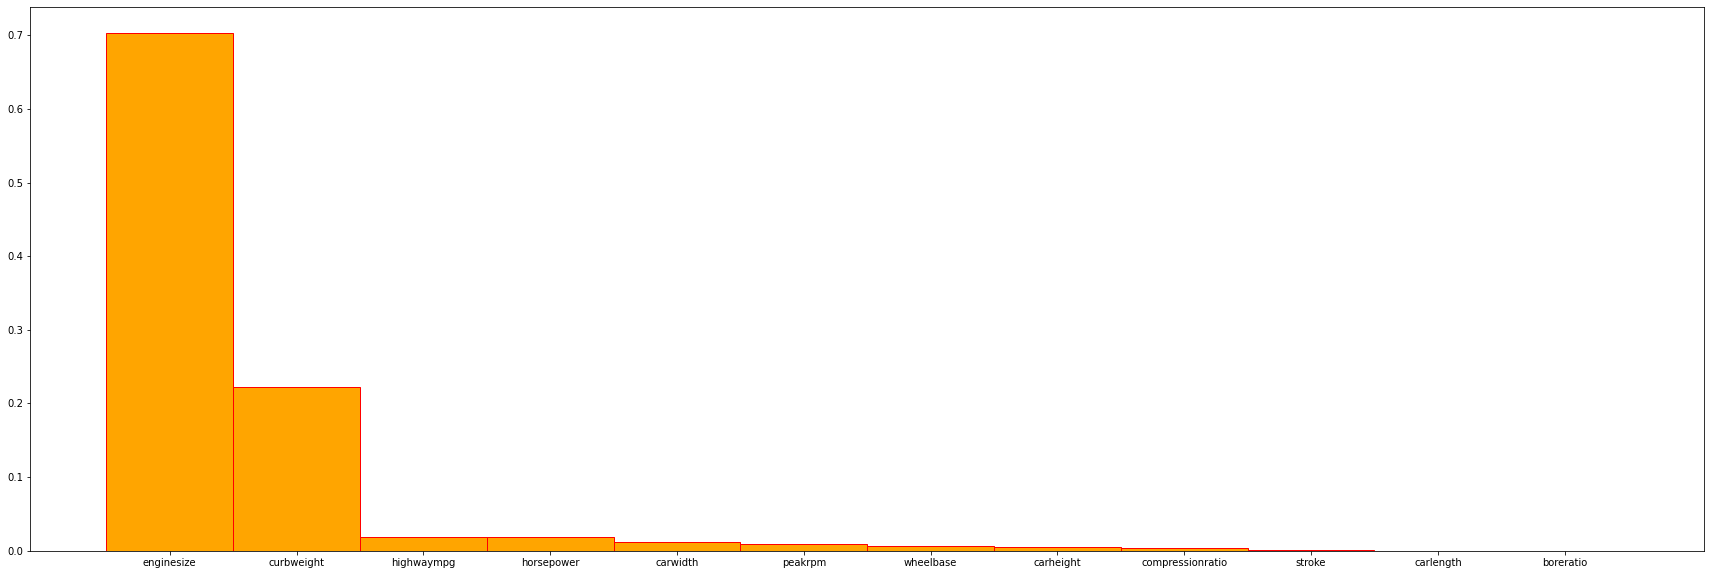

In [207]:
df = pd.DataFrame(dtr.feature_importances_,index=X_dt.columns.values, columns=["Feature_Score"])
df1 = df.sort_values(ascending=False,by=["Feature_Score"])
plt.figure(figsize=(30,10))
plt.bar(df1.index, df1.Feature_Score, width=1, color='orange',edgecolor='red' )
df1

In [201]:
# R-Squared is a method of 
y_pred_dt = dtr.predict(X_dt_test)
print("\nR-Squared-->>",dtr.score(X_dt_test, y_dt_test))
print("\nParameters used by the Regressor -->>", dtr.get_params())
print("\nNumber of leaves of the Tree -->>", dtr.get_n_leaves())
print("\nDepth of the Tree -->>", dtr.get_depth())
print(pd.DataFrame(np.array([y_pred_dt, y_dt_test]).T, columns=["Pred","Actual"]))


R-Squared-->> 0.8917898053497048

Parameters used by the Regressor -->> {'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

Number of leaves of the Tree -->> 59

Depth of the Tree -->> 7
            Pred   Actual
0   15351.500000  16695.0
1   11549.000000  11199.0
2   22018.000000  20970.0
3   45400.000000  40960.0
4   11694.000000  11259.0
5    8327.250000   6575.0
6   15351.500000  11900.0
7   18920.000000  23875.0
8   10170.000000   8845.0
9    6720.500000   5499.0
10  13971.500000  12629.0
11   8170.545455   8238.0
12  25552.000000  28176.0
13  11595.000000   9298.0
14   7609.000000   6692.0
15   9666.650000   9549.0
16  15351.500000  15510.0
17   8170.545455   7957.0
18   9408.500000   9279.0
19   9666.650000  13845.0
20   7348.375000   7999.0
21  13971.